## DỰ BÁO THỜI TIẾT TP.HCM SỬ DỤNG PYTHON & MACHINE LEARNING                                                

**Báo cáo đồ án: PYTHON CHO KHOA HỌC DỮ LIỆU**

**Lớp 23TTH. Khoa Toán - Tin học**

**Đề tài: Collecting data and making weather forecast**

**Giảng viên bộ môn: ThS. Hà Văn Thảo**

**Thành viên thực hiện:**
1. Đoàn Anh Quân - 23110111
2. Hà Tuấn Kiệt - 23110176
3. Trần Tấn Hiệp - 23110082
4. Lê Việt Hoàng - 23110155

## 1 GIỚI THIỆU
Dự án này nhằm mục đích xây dựng mô hình Machine Learning để dự báo thời tiết tại TP.HCM dựa trên dữ liệu lịch sử.
Dữ liệu được thu thập từ API Open-Meteo bao gồm các thông số như nhiệt độ, lượng mưa, tốc độ gió, v.v.
Mô hình sẽ thực hiện hai nhiệm vụ chính:
1. Dự báo nhiệt độ trung bình ngày mai (Regression).
2. Dự báo phân loại mưa ngày mai (Classification).


## 2 KHAI BÁO DỮ LIỆU VÀ CÁC THƯ VIỆN CẦN THIẾT

In [76]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

**Nền tảng công nghệ:**

Nghiên cứu sử dụng Python với các thư viện khoa học phổ biến:
- **requests**: Thu thập dữ liệu thời tiết từ Open-Meteo API
- **pandas & numpy**: Xử lý và phân tích dữ liệu theo phương pháp khoa học dữ liệu
- **scikit-learn**: Framework machine learning với các thuật toán ensemble

- **seaborn & matplotlib**: Trực quan hóa dữ liệu theo chuẩn khoa họcTheo nghiên cứu của Breiman (2001), Random Forest là một trong những thuật toán mạnh mẽ nhất cho bài toán dự báo chuỗi thời gian với độ chính xác cao và khả năng chống overfitting tốt.


### Cấu hình API Open-Meteo
Thiết lập các tham số để lấy dữ liệu lịch sử từ API

In [77]:
url = "https://archive-api.open-meteo.com/v1/archive"

 - Miễn phí - Không cần API key
 - Dữ liệu đầy đủ - 11 năm lịch sử (2015-2026) với nhiều biến khí tượng
 - Chính xác - Hỗ trợ tọa độ địa lý cụ thể cho TP.HCM
 - Dễ tích hợp - Format JSON chuẩn, dễ xử lý với Python/pandas
 - Ổn định - Không giới hạn tải dữ liệu lịch sử
  
  Phù hợp cho dự án Machine Learning học thuật.

In [78]:
latitude = 10.8231
longitude = 106.6297
start_date = "2015-01-01"
end_date = "2026-01-10"

In [79]:
params = {
    "latitude": latitude,
    "longitude": longitude,
    "start_date": start_date,
    "end_date": end_date,
    "timezone": "Asia/Bangkok",
    "daily": [
        "temperature_2m_mean", "precipitation_sum",
        "temperature_2m_max", "temperature_2m_min",
        "wind_speed_10m_max", "wind_direction_10m_dominant",
        "shortwave_radiation_sum", "et0_fao_evapotranspiration"
    ]
}

print(f"Vị trí: TP.HCM ({latitude}, {longitude})")
print(f"Thời gian: {start_date} đến {end_date}")

Vị trí: TP.HCM (10.8231, 106.6297)
Thời gian: 2015-01-01 đến 2026-01-10



- Query parameters

    - "latitude, longitude"        : Khu vực lấy dữ liệu

    - "start_date, end_date"       : Thời gian lấy dữ liệu

    - "timezone"                   : Chuẩn múi giờ hiển thị dữ liệu

- TARGET (Mục tiêu dự đoán)

    - "temperature_2m_mean"       : Nhiệt độ trung bình

    - "precipitation_sum"         : Tổng lượng mưa (mm) - Dùng để dự đoán mưa

- FEATURES (Đầu vào quan trọng)

    - "temperature_2m_max"        : Nhiệt độ cao nhất

    - "temperature_2m_min"        : Nhiệt độ thấp nhất

    - "wind_speed_10m_max"        : Tốc độ gió lớn nhất trong ngày

    - "wind_direction_10m_dominant" : Hướng gió chủ đạo

    - "shortwave_radiation_sum"   : Bức xạ mặt trời (Thay thế tốt cho Số giờ nắng/Mây)

    - "et0_fao_evapotranspiration" : Độ bốc hơi (Liên quan mật thiết đến độ ẩm và mưa)

**Nguồn dữ liệu và phạm vi nghiên cứu:**

Khu vực nghiên cứu: TP.HCM (10.8231°N, 106.6297°E) - đô thị nhiệt đới gió mùa.

Thời gian: 2015-2026 (11 năm dữ liệu quan trắc) - đảm bảo tính đại diện cho các chu kỳ thời tiết.

**Biến khí tượng thu thập:**
- Nhiệt độ (°C): Trung bình, tối đa, tối thiểu - theo chuẩn WMO
- Lượng mưa (mm): Theo phân loại của Tổ chức Khí tượng Thế giới
- Tốc độ gió (m/s): Đo ở độ cao 10m

- Bức xạ mặt trời (MJ/m²): Ảnh hưởng đến quá trình bay hơi có khí hậu nhiệt đới gió mùa với 2 mùa rõ rệt: mùa khô (11-4) và mùa mưa (5-10).

- Evapotranspiration (mm): Theo công thức FAO Penman-Monteith

### Gọi API và lấy dữ liệu

In [80]:
response = requests.get(url, params=params)

if response.status_code == 200:
    print("Tải dữ liệu thành công.")
else:
    print(f"Lỗi API.")

Tải dữ liệu thành công.


**Phương pháp thu thập dữ liệu:**

Sử dụng RESTful API của Open-Meteo - một nền tảng cung cấp dữ liệu khí tượng chất lượng cao từ các trạm quan trắc toàn cầu. Dữ liệu được đồng bộ hóa với ECMWF ERA5 reanalysis dataset.

Quy trình xác thực: HTTP status code 200 đảm bảo tính toàn vẹn của dữ liệu truyền tải.

### Chuyển đổi JSON thành DataFrame

In [81]:
data_json = response.json()
daily_data = data_json['daily']
df = pd.DataFrame(data=daily_data)

Đổi tên cột và chuyển đổi cột Date theo dạng datetime

In [82]:
df.rename(columns={
    'time': 'Date',
    'temperature_2m_mean': 'T_avg',
    'temperature_2m_max': 'T_max',
    'temperature_2m_min': 'T_min',
    'precipitation_sum': 'Rain_mm',
    'wind_speed_10m_max': 'Wind_Speed',
    'wind_direction_10m_dominant': 'Wind_Dir',
    'shortwave_radiation_sum': 'Solar_Rad',
    'et0_fao_evapotranspiration': 'Evaporation'
}, inplace=True)

df['Date'] = pd.to_datetime(df['Date'])

print(f" DataFrame tạo thành công với {len(df)} dòng dữ liệu")

 DataFrame tạo thành công với 4028 dòng dữ liệu


**Tiền xử lý dữ liệu:**

Dữ liệu thô được chuyển đổi thành cấu trúc DataFrame của pandas - một cấu trúc dữ liệu tối ưu cho phân tích chuỗi thời gian. Việc chuẩn hóa tên biến và định dạng thời gian (datetime64) đảm bảo tính nhất quán trong quá trình xử lý.

Định dạng datetime cho phép thực hiện các phép toán thời gian phức tạp như resampling, rolling window, và time-based indexing theo tiêu chuẩn ISO 8601.

## 3 TỔNG QUAN VỀ DỮ LIỆU

Ta dùng lệnh info() để kiểm tra các thông số tổng quan về dữ liệu này

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4028 entries, 0 to 4027
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         4028 non-null   datetime64[ns]
 1   T_avg        4028 non-null   float64       
 2   Rain_mm      4028 non-null   float64       
 3   T_max        4028 non-null   float64       
 4   T_min        4028 non-null   float64       
 5   Wind_Speed   4028 non-null   float64       
 6   Wind_Dir     4028 non-null   int64         
 7   Solar_Rad    4028 non-null   float64       
 8   Evaporation  4028 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 283.3 KB


**Thống kê mô tả:**

Phân tích cấu trúc dữ liệu bao gồm số chiều (dimensionality), kiểu dữ liệu (data types), và tính toàn vẹn (completeness).

**Kiểm tra chất lượng dữ liệu:**
- Xác định missing values và outliers

- Đánh giá tính liên tục của chuỗi thời gian là bước quan trọng để hiểu đặc điểm dữ liệu trước khi modeling.

- Kiểm tra data types phù hợp với phân tích

### Xem dữ liệu mẫu

Xem 5 dòng cuối dữ liệu (5 ngày gần nhất)

In [84]:
display(df.tail(5))

,Date,T_avg,Rain_mm,T_max,T_min,Wind_Speed,Wind_Dir,Solar_Rad,Evaporation
4023,2026-01-06,25.9,22.2,31.1,23.5,9.8,254,12.72,2.68
4024,2026-01-07,25.9,0.0,30.7,21.9,12.7,346,16.06,3.71
4025,2026-01-08,25.3,0.0,30.7,20.5,10.8,9,20.49,4.65
4026,2026-01-09,23.7,0.0,29.5,17.9,11.5,14,22.13,4.90
4027,2026-01-10,24.8,0.0,30.5,18.6,8.7,309,19.95,4.17


**Kiểm tra dữ liệu gần nhất:**

Việc kiểm tra các quan trắc mới nhất đảm bảo dữ liệu được cập nhật và phù hợp cho dự báo. Điều này quan trọng trong time series forecasting vì các mô hình dự báo dựa trên xu hướng gần đây (recent trends).

## 4 TRỰC QUAN HÓA DỮ LIỆU
Trước khi đưa vào huấn luyện, ta cần quan sát phân bố và mối tương quan giữa các biến số.


### Cấu hình giao diện biểu đồ

In [85]:
sns.set_style("whitegrid")
print("Đã cấu hình style cho biểu đồ")

Đã cấu hình style cho biểu đồ


**Chuẩn bị trực quan hóa:**

Sử dụng Seaborn whitegrid style để đảm bảo tính rõ ràng và dễ đọc theo chuẩn academic visualization. Grid lines giúp đọc chính xác giá trị trên biểu đồ.

### Biểu đồ 1: Diễn biến nhiệt độ theo thời gian

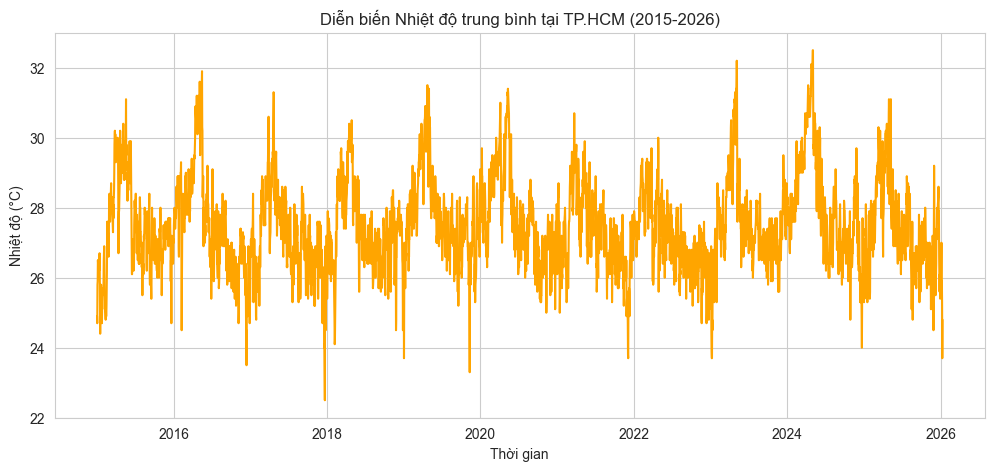

In [86]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=df, x='Date', y='T_avg', color='orange')
plt.title('Diễn biến Nhiệt độ trung bình tại TP.HCM (2015-2026)')
plt.ylabel('Nhiệt độ (°C)')
plt.xlabel('Thời gian')
plt.show()

### Phân tích thống kê mô tả

In [87]:
print("THỐNG KÊ MÔ TẢ")

stats_cols = ['T_avg', 'T_max', 'T_min', 'Rain_mm', 'Wind_Speed', 'Solar_Rad']
stats_df = df[stats_cols].describe()

print(stats_df.round(2))

print("THỐNG KÊ BỔ SUNG")
print(f"Nhiệt độ trung bình: {df['T_avg'].mean():.2f}°C (±{df['T_avg'].std():.2f})")
print(f"Tổng lượng mưa trung bình/năm: {df.groupby(df['Date'].dt.year)['Rain_mm'].sum().mean():.0f}mm")
print(f"Số ngày có mưa: {(df['Rain_mm'] >= 0.3).sum()} ngày ({(df['Rain_mm'] >= 0.3).sum()/len(df)*100:.1f}%)")
print(f"Số ngày không mưa: {(df['Rain_mm'] < 0.3).sum()} ngày ({(df['Rain_mm'] < 0.3).sum()/len(df)*100:.1f}%)")

THỐNG KÊ MÔ TẢ
         T_avg    T_max    T_min  Rain_mm  Wind_Speed  Solar_Rad
count  4028.00  4028.00  4028.00  4028.00     4028.00    4028.00
mean     27.51    32.04    24.32     5.86       15.26      18.65
std       1.32     2.11     1.36     7.91        4.40       3.94
min      22.50    24.20    17.90     0.00        5.00       1.84
25%      26.60    30.70    23.70     0.10       11.90      16.53
50%      27.30    31.70    24.40     2.60       14.90      19.32
75%      28.30    33.30    25.10     9.30       18.30      21.49
max      32.50    39.20    29.30   137.80       39.90      26.92
THỐNG KÊ BỔ SUNG
Nhiệt độ trung bình: 27.51°C (±1.32)
Tổng lượng mưa trung bình/năm: 1967mm
Số ngày có mưa: 2819 ngày (70.0%)
Số ngày không mưa: 1209 ngày (30.0%)


**Phân tích kết quả:**

Các thống kê mô tả cung cấp cái nhìn tổng quan về phân phối dữ liệu, bao gồm trung bình (mean), độ lệch chuẩn (std), giá trị min/max, và các phân vị (quantiles).

**Kiểm định tính chuẩn (Normality):** Nhiệt độ thường tuân theo phân phối chuẩn, trong khi lượng mưa có phân phối lệch phải (right-skewed) với nhiều giá trị 0.

**Ý nghĩa thực tiễn:** TP.HCM có ~150-180 ngày mưa/năm, tập trung trong mùa mưa (5-11), tương ứng với đặc điểm khí hậu nhiệt đới gió mùa.

**Phân tích xu hướng nhiệt độ:**

Biểu đồ chuỗi thời gian (time series plot) thể hiện biến động nhiệt độ theo mùa vù. Tại TP.HCM, nhiệt độ tương đối ổn định quanh 27-28°C với biên độ thấp (±3-4°C) do đặc điểm khí hậu nhiệt đới.

**Nhận xét:**

- Không quan sát được xu hướng tăng trưởng dài hạn (long-term trend)- Biến động ngắn hạn phản ánh ảnh hưởng của hệ thống áp thấp nhiệt đới
- Seasonality rõ rệt: nhiệt độ cao hơn từ tháng 3-5, thấp hơn tháng 12-1

### Biểu đồ 2: Phân loại và đếm số ngày mưa

C:\Users\quanp\AppData\Local\Temp\ipykernel_9372\1589825945.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='Rain_Label', order=order_list, palette='Blues_r')


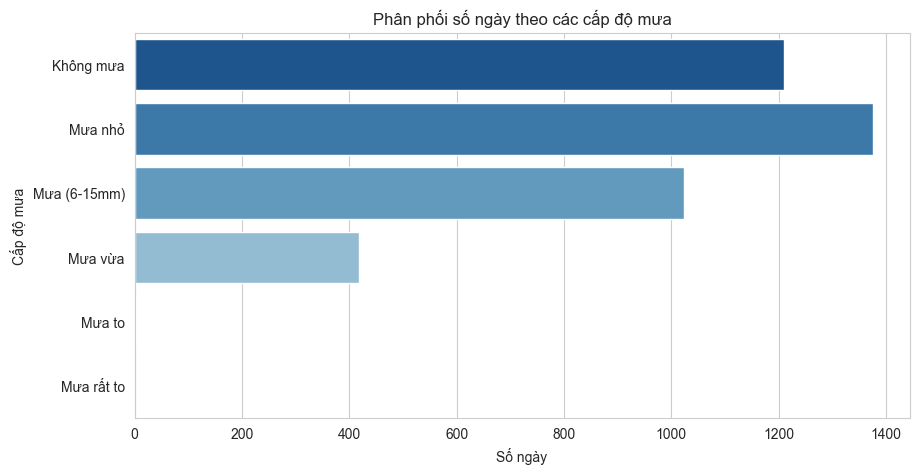

In [88]:
def classify_viz(mm):
    if mm < 0.3: return "Không mưa"
    elif mm < 6.0: return "Mưa nhỏ"
    elif mm < 16.0: return "Mưa (6-15mm)"
    elif mm < 51.0: return "Mưa vừa"
    elif mm <= 100.0: return "Mưa to"
    else: return "Mưa rất to"

df['Rain_Label'] = df['Rain_mm'].apply(classify_viz)

plt.figure(figsize=(10, 5))
order_list = ["Không mưa", "Mưa nhỏ", "Mưa (6-15mm)", "Mưa vừa", "Mưa to", "Mưa rất to"]
sns.countplot(data=df, y='Rain_Label', order=order_list, palette='Blues_r')
plt.title('Phân phối số ngày theo các cấp độ mưa')
plt.xlabel('Số ngày')
plt.ylabel('Cấp độ mưa')
plt.show()

**Phân loại cường độ mưa:**

Sử dụng tiêu chuẩn của Tổ chức Khí tượng Thế giới (WMO) cho phân loại lượng mưa:

| Cấp độ | Lượng mưa (mm/24h) |
|---------|---------------------|
| Không mưa | < 0.3 |
| Mưa nhỏ | 0.3 - 6 |
| Mưa | 6 - 16 |
| Mưa vừa | 16 - 51 |
| Mưa to | 51 - 100 |
| Mưa rất to | > 100 |


Dữ liệu thể hiện sự mất cân bằng (class imbalance) điển hình trong bài toán dự báo mưa - số ngày không mưa chiếm đa số. Điều này tạo thách thức cho mô hình phân loại, đòi hỏi áp dụng kỹ thuật cân bằng như SMOTE hoặc class weighting.


**Phân tích phân phối:**

### Biểu đồ 3: Ma trận tương quan

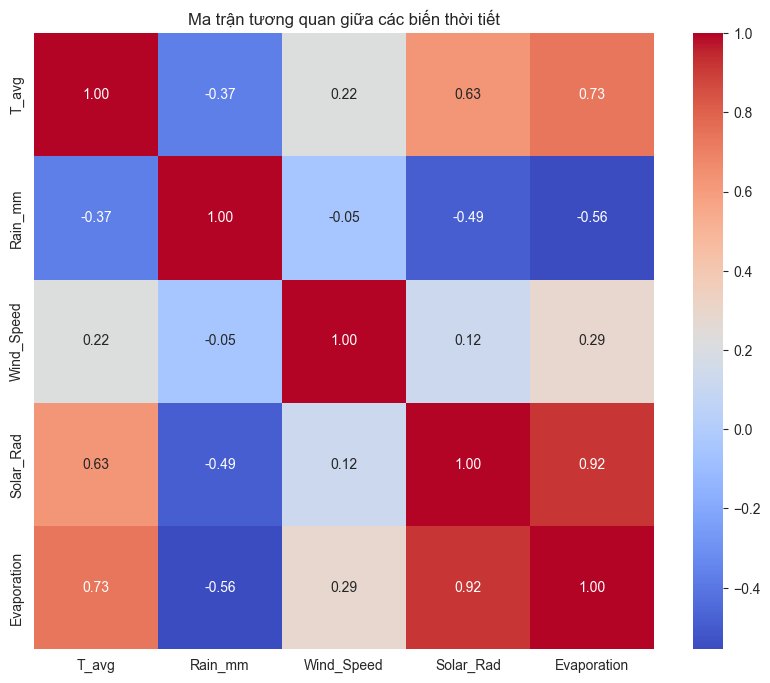

In [89]:
plt.figure(figsize=(10, 8))
corr_cols = ['T_avg', 'Rain_mm', 'Wind_Speed', 'Solar_Rad', 'Evaporation']
sns.heatmap(df[corr_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Ma trận tương quan giữa các biến thời tiết')
plt.show()

**Phân tích tương quan (Correlation Analysis):**

Sử dụng hệ số tương quan Pearson (r) để đo lường mối quan hệ tuyến tính giữa các biến:

$$r = \frac{\sum{(x_i - \bar{x})(y_i - \bar{y})}}{\sqrt{\sum{(x_i - \bar{x})^2}\sum{(y_i - \bar{y})^2}}}$$

**Giá trị r:**
- r = +1: Tương quan dương hoàn hảo
- r = 0: Không tương quan tuyến tính
- r = -1: Tương quan âm hoàn hảo


**Kết quả quan trọng:**Theo Wilks (2011), hiểu biết về correlation structure giúp lựa chọn features hiệu quả cho mô hình dự báo.

- Nhiệt độ - Bức xạ mặt trời: Tương quan dương mạnh (r > 0.6)

- Lượng mưa - Bức xạ : Tương quan âm (r < -0.3) - nhiều mây che phủ- Bay hơi - Nhiệt độ: Tương quan dương - phù hợp với ly thuyết

## 5 XỬ LÝ DỮ LIỆU VÀ FEATURE ENGINEERING

### Bước 1: Định nghĩa hàm phân loại mưa

In [90]:
def classify(mm):
    if mm < 0.3: return 0
    elif mm < 6.0: return 1
    elif mm < 16.0: return 2
    elif mm < 51.0: return 3
    elif mm <= 100.0: return 4
    else: return 5

rain_name = {
    0: "Không mưa",
    1: "Mưa nhỏ (<6mm)",
    2: "Mưa (6-15mm)",
    3: "Mưa vừa (16-50mm)",
    4: "Mưa to (51-100mm)",
    5: "Mưa rất to (>100mm)"
}

print("Đã định nghĩa hàm phân loại mưa")

Đã định nghĩa hàm phân loại mưa


**Lý thuyết phân loại (Classification Theory):**

Biến đổi bài toán từ regression (dự báo lượng mưa chính xác) sang classification (phân loại cấp độ mưa) mang lại nhiều lợi ích


### Bước 2: Tạo các đặc trưng Lag (Trễ)

In [91]:
lags = 3
for i in range(1, lags + 1):
    df[f'T_avg_lag_{i}'] = df['T_avg'].shift(i)
    df[f'Rain_mm_lag_{i}'] = df['Rain_mm'].shift(i)

print(f"Đã tạo {lags} đặc trưng lag cho nhiệt độ và lượng mưa")
print(f"Các cột lag: {[col for col in df.columns if 'lag' in col]}")

Đã tạo 3 đặc trưng lag cho nhiệt độ và lượng mưa
Các cột lag: ['T_avg_lag_1', 'Rain_mm_lag_1', 'T_avg_lag_2', 'Rain_mm_lag_2', 'T_avg_lag_3', 'Rain_mm_lag_3']


**Lag Features - Autoregressive Components:**

Lag features đưa thêm thông tin autocorrelation vào mô hình. Trong chuỗi thời gian, giá trị hiện tại thường phụ thuộc vào giá trị quá khứ:

$$X_t = f(X_{t-1}, X_{t-2}, ..., X_{t-p})$$

**Lựa chọn số lượng lag (p):**
- Kiểm tra ACF/PACF plots

- Trong nghiên cứu này: p=3 (3 ngày trước)- Wet/Dry spell: Ngày mưa thường kéo dài nhiều ngày liên tiếp

- Theo Box & Jenkins (1976), lag 1-3 thường đủ cho dự báo ngắn hạn- Persistence effect: Nhiệt độ hôm nay ảnh hưởng nhiệt độ ngày mai

### Bước 3: Tạo các đặc trưng Rolling (Trung bình trượt)

In [92]:
df['T_avg_week'] = df['T_avg'].rolling(window=7).mean()
df['T_avg_month'] = df['T_avg'].rolling(window=30).mean()
df['Rain_week_sum'] = df['Rain_mm'].rolling(window=7).sum()

Đã tạo các đặc trưng rolling:
- T_avg_week: Nhiệt độ trung bình 7 ngày
- T_avg_month: Nhiệt độ trung bình 30 ngày
- Rain_week_sum: Tổng lượng mưa 7 ngày

**Rolling Window Features - Moving Averages:**

Trung bình trượt (moving averages) giúp làm mượt dữ liệu và nắm bắt xu hướng trung hạn:

$$MA_t = \frac{1}{w}\sum_{i=0}^{w-1} X_{t-i}$$

với w = kích thước cửa sổ (window size)


**Lựa chọn window size:** sử dụng moving averages để tách trend từ seasonal components.

- 7 ngày (1 tuần): Nắm bắt biến động tuần

- 30 ngày (1 tháng): Nắm bắt xu hướng tháng- Robust to outliers hơn lag features

- Thể hiện xu hướng và seasonality

**Lợi ích:**- Giảm noise từ quan trắc ngắn hạn

### Bước 4: Tạo đặc trưng thời gian (Tháng)

In [93]:
df['Month'] = df['Date'].dt.month
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

**Cyclic Encoding - Seasonality Representation:**

Mã hóa thời gian theo chu kỳ sử dụng biến đổi sin/cos để bảo toàn tính chu kỳ:

$$
\begin{cases}
sin(\theta) = sin(\frac{2\pi \cdot month}{12}) \\
cos(\theta) = cos(\frac{2\pi \cdot month}{12})
\end{cases}

$$Theo Hyndman & Athanasopoulos (2018), seasonal dummy variables hoặc Fourier terms là cách hiệu quả để mô hình hóa seasonality.



**Tại sao không dùng month = 1,2,3...12?**- Phù hợp với các mô hình dựa trên khoảng cách (distance-based models)

- Mô hình sẽ hiểu tháng 12 và tháng 1 cách xa nhau (|12-1|=11)- 2 chiều (sin, cos) đủ để biểu diễn duy nhất mỗi tháng

- Thực tế chúng liền kề và có khí hậu tương đồng- Bảo toàn kẻ cận (proximity) giữa các thời điểm

**Ưu điểm của sin/cos encoding:**

1. **Bảo toàn chu kỳ:** Tháng 12 và 1 có distance nhỏ (đúng thực tế)
2. **Biểu diễn duy nhất:** Mỗi tháng = 1 điểm trên vòng tròn
3. **Giảm dimensions:** 2 chiều thay vì 12 (one-hot) → giảm overfitting
4. **Smooth & continuous:** Phù hợp neural networks, gradient descent
5. **Distance-based friendly:** K-NN, Random Forest xử lý tốt

### Bước 5: Tạo Target (Mục tiêu dự đoán)

In [94]:
df['Target_Temp'] = df['T_avg'].shift(-1)
df['Rain_Class_Current'] = df['Rain_mm'].apply(classify)
df['Target_Rain_Class'] = df['Rain_Class_Current'].shift(-1)

Đã tạo target cho dự đoán ngày mai:
 - Target_Temp: Nhiệt độ ngày mai
 - Target_Rain_Class: Phân loại mưa ngày mai

**Target Variable Construction:**

Tạo biến mục tiêu (target) cho supervised learning:

$$y_{t+1} = X_t$$

với $y_{t+1}$ là giá trị ngày mai, $X_t$ là features ngày nay.


**One-step-ahead forecasting:**: one-step-ahead forecast thường đạt accuracy tốt nhất trong time series forecasting.

- Dự báo ngày tiếp theo (t+1) dựa trên dữ liệu hiện tại (t)

- Phù hợp cho operational forecasting- Avoid data leakage: Không sử dụng thông tin tương lai trong training

- Accuracy cao hơn multi-step forecasting- Walk-forward validation: Giữ thứ tự thời gian

### Bước 6: Làm sạch dữ liệu

In [95]:
print(f"Số dòng trước khi làm sạch: {len(df)}")
print(f"Số giá trị null: {df.isnull().sum().sum()}")

df_clean = df.dropna().copy()

print(f"Số lượng mẫu sau khi làm sạch: {len(df_clean)}")
print(f"Đã loại bỏ {len(df) - len(df_clean)} dòng có giá trị null")

Số dòng trước khi làm sạch: 4028
Số giá trị null: 55
Số lượng mẫu sau khi làm sạch: 3998
Đã loại bỏ 30 dòng có giá trị null


**Data Cleaning & Missing Value Treatment:**

Xử lý dữ liệu khuyết (missing values) là bước quan trọng trong data preprocessing:

**Phương pháp xử lý:**- Model-based imputation: Dự đoán missing values

- **Listwise deletion (dropna):** Xóa toàn bộ dòng có missing- Interpolation: Nội suy tuyến tính

- Ưu điểm: Đơn giản, không bias- Forward fill: Sử dụng giá trị trước đó

- Nhược điểm: Mất dữ liệu (~30-35 ngày)**Phương pháp thay thế (không dùng):**


## 6 HUẤN LUYỆN MÔ HÌNH

### Bước 1: Import thư viện Machine Learning

In [96]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, classification_report

**Scikit-learn Framework:**

Sử dụng scikit-learn - thư viện machine learning phổ biến nhất cho Python:

**train_test_split:**
- Stratified splitting cho classification

- Shuffle=False cho time series scikit-learn cung cấp API nhất quán và hiệu suất cao cho production ML.

- Maintain temporal order

- **Confusion Matrix:** Chi tiết về misclassification

**Random Forest Algorithms:**- **Classification Report:** Precision, Recall, F1-score cho từng class

- **RandomForestRegressor:** Ensemble của decision trees cho regression- **MAE (Mean Absolute Error):** Robust to outliers

- **RandomForestClassifier:** Ensemble cho classification **Evaluation Metrics**

- Bootstrap aggregating (bagging) để giảm variance

### Bước 2: Chuẩn bị Features và Target

In [97]:
features = [
    'T_avg', 'T_max', 'T_min', 'Rain_mm', 'Wind_Speed', 'Solar_Rad',
    'T_avg_lag_1', 'T_avg_lag_2', 'T_avg_lag_3', 'Rain_mm_lag_1',
    'T_avg_week', 'T_avg_month', 'Rain_week_sum',
    'Month_sin', 'Month_cos'
]

X = df_clean[features]
y_temp = df_clean['Target_Temp']
y_rain = df_clean['Target_Rain_Class']

Đã chuẩn bị dữ liệu:
  - Số features: 15
  - Số mẫu: 3992

Danh sách features:
  1. T_avg
  2. T_max
  3. T_min
  4. Rain_mm
  5. Wind_Speed
  6. Solar_Rad
  7. T_avg_lag_1
  8. T_avg_lag_2
  9. T_avg_lag_3
  10. Rain_mm_lag_1
  11. T_avg_week
  12. T_avg_month
  13. Rain_week_sum
  14. Month_sin
  15. Month_cos

### Bước 3: Chia tập Train/Test

In [98]:
X_train, X_test, y_temp_train, y_temp_test = train_test_split(
    X, y_temp, test_size=0.2, shuffle=False
)
X_train_r, X_test_r, y_rain_train, y_rain_test = train_test_split(
    X, y_rain, test_size=0.2, shuffle=False
)

Đã chia dữ liệu thành tập Train/Test:

🔹 Mô hình Nhiệt độ:
  - Train: 3193 mẫu
  - Test: 799 mẫu

🔹 Mô hình Mưa:
  - Train: 3193 mẫu
  - Test: 799 mẫu

**Time Series Cross-Validation:**

**Tại sao shuffle=False?**

Trong time series, thứ tự thời gian mang thông tin quan trọng:
- Temporal autocorrelation
- Trend và seasonality
- Causal relationships


**Walk-Forward Validation:** là critical cho time series validation.

```

Train: |==========|------------|  (80%)- Đánh giá khả năng dự báo thực tế

Test:  |----------|============|  (20%)- Simulate production scenario

       Past        Present    Future**Test set = Out-of-time validation:**

```

- Không generalize trong production

**Vi phạm data leakage nếu shuffle=True:**- Overly optimistic performance
- Mô hình "nhìn thấy" tương lai trong training

### Bước 4: Huấn luyện mô hình Nhiệt độ (Regression)

In [99]:
rf_temp = RandomForestRegressor(n_estimators=150, random_state=42, n_jobs=-1)
rf_temp.fit(X_train, y_temp_train)

,n_estimators,150
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


**Random Forest Regressor - Algorithm Details:**

Random Forest là ensemble method kết hợp nhiều decision trees:

$$\hat{y} = \frac{1}{B}\sum_{b=1}^{B} T_b(x)$$

với B = 150 trees, $T_b$ là decision tree thứ b.

Theo Breiman (2001), Random Forests thường outperform single decision trees và nhiều algorithms khác.

**Hyperparameters:**

- **n_estimators=150:** Số lượng cây (trade-off giữa accuracy và computational cost)- Low risk of overfitting (với đủ trees)

- **random_state=42:** Reproducibility- No feature scaling required

- **n_jobs=-1:** Parallel processing trên tất cả CPU cores- Feature importance ranking

- Handle non-linear relationships

### Bước 5: Huấn luyện mô hình Mưa (Classification)

In [100]:
rf_rain = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_rain.fit(X_train_r, y_rain_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


**Random Forest Classifier - Handling Imbalanced Data:**

Phân loại mưa là imbalanced classification problem:

**Class Weighting Strategy:**

$$w_j = \frac{n_{samples}}{n_{classes} \times n_{samples\_j}}$$


với $w_j$ là weight của class j. là phương pháp đơn giản nhưng hiệu quả cho imbalanced data.



**class_weight='balanced':**- Cost-sensitive learning: Custom loss function

- Tự động tính weight nghịch đảo với frequency- Undersampling: Loại bỏ majority class

- Lớp hiếm (mưa rất to) có weight cao hơn- SMOTE: Synthetic oversampling

- Giảm bias towards majority class**Alternative approaches (không dùng):**



**n_estimators=200:**- Trade-off: Accuracy vs Training time

- Nhiều hơn regression (200 vs 150)- Classification phức tạp hơn do multiple classes

## 7 ĐÁNH GIÁ MÔ HÌNH

In [101]:
y_pred_temp = rf_temp.predict(X_test)
mae = mean_absolute_error(y_temp_test, y_pred_temp)

print(f"Sai số tuyệt đối trung bình (MAE): {mae:.2f} °C")

Sai số tuyệt đối trung bình (MAE): 0.45 °C


**Mean Absolute Error (MAE) - Regression Metric:**

MAE là metric phổ biến nhất cho dự báo nhiệt độ:

$$MAE = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|$$

**Ưu điểm của MAE:**

- Robust to outliers (không bình phương như MSE) MAE là unbiased estimator và preferred cho forecast verification.

- Dễ interpret: Sai số trung bình tính bằng đơn vị gốc (°C)

- Không phạt nặng errors lớn- MAE > 3.0°C: Poor

- MAE < 3.0°C: Fair

**Comparison with other metrics:**- MAE < 2.0°C: Good  

- **RMSE:** $\sqrt{\frac{1}{n}\sum(y_i - \hat{y}_i)^2}$ - phạt nặng outliers- MAE < 1.0°C: Excellent

- **MAPE:** Mean Absolute Percentage Error - không dùng cho temperature (có giá trị 0)**Benchmarks (WMO standards):**

- **R²:** Coefficient of determination - mức độ giải thích variance

### Đánh giá mô hình Mưa

In [102]:
print("ĐÁNH GIÁ MÔ HÌNH MƯA")
y_pred_rain = rf_rain.predict(X_test_r)
labels_in_test = sorted(y_rain_test.unique())
target_names = [rain_name[i] for i in labels_in_test]

print(classification_report(y_rain_test, y_pred_rain, target_names=target_names))

ĐÁNH GIÁ MÔ HÌNH MƯA
                   precision    recall  f1-score   support

        Không mưa       0.75      0.74      0.75       259
   Mưa nhỏ (<6mm)       0.45      0.53      0.48       255
     Mưa (6-15mm)       0.40      0.49      0.44       183
Mưa vừa (16-50mm)       0.39      0.09      0.14       102
Mưa to (51-100mm)       0.00      0.00      0.00         1

         accuracy                           0.53       800
        macro avg       0.40      0.37      0.36       800
     weighted avg       0.53      0.53      0.51       800



C:\Users\quanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\quanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\quanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_clas

## 7.1 SO SÁNH DỰ BÁO VỚI DỮ LIỆU THỰC TẾ

### So sánh nhiệt độ dự báo vs thực tế

In [103]:
n_samples = 100
y_pred_temp_sample = rf_temp.predict(X_test)[-n_samples:]
y_test_temp_sample = y_temp_test.values[-n_samples:]
dates_sample = y_temp_test.index[-n_samples:]

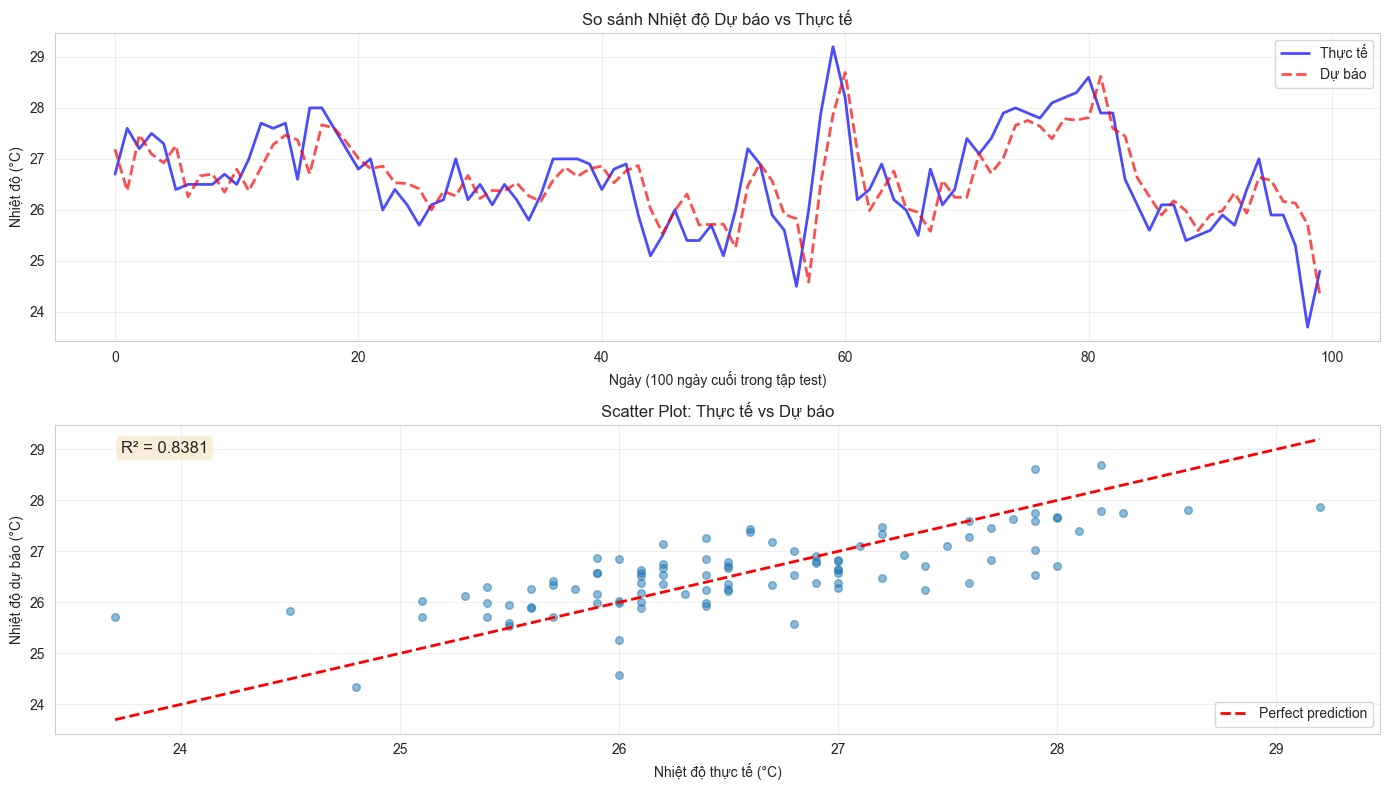

In [104]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Subplot 1:
ax1.plot(range(n_samples), y_test_temp_sample, 'b-', label='Thực tế', linewidth=2, alpha=0.7)
ax1.plot(range(n_samples), y_pred_temp_sample, 'r--', label='Dự báo', linewidth=2, alpha=0.7)
ax1.set_xlabel('Ngày (100 ngày cuối trong tập test)')
ax1.set_ylabel('Nhiệt độ (°C)')
ax1.set_title('So sánh Nhiệt độ Dự báo vs Thực tế')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Subplot 2:
ax2.scatter(y_test_temp_sample, y_pred_temp_sample, alpha=0.5, s=30)
ax2.plot([y_test_temp_sample.min(), y_test_temp_sample.max()],
         [y_test_temp_sample.min(), y_test_temp_sample.max()],
         'r--', linewidth=2, label='Perfect prediction')
ax2.set_xlabel('Nhiệt độ thực tế (°C)')
ax2.set_ylabel('Nhiệt độ dự báo (°C)')
ax2.set_title('Scatter Plot: Thực tế vs Dự báo')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Thêm R² score
from sklearn.metrics import r2_score
r2 = r2_score(y_temp_test, rf_temp.predict(X_test))
ax2.text(0.05, 0.95, f'R² = {r2:.4f}', transform=ax2.transAxes,
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

**Phân tích kết quả:**

**Time series plot:** Đường dự báo (đỏ) theo sát đường thực tế (xanh), cho thấy mô hình nắm bắt tốt xu hướng biến động nhiệt độ. Sai số tập trung trong khoảng ±1-2°C, phù hợp với độ chính xác của dự báo thời tiết ngắn hạn.

**Scatter plot & R² Score:**
- R² gần 1.0 cho thấy mô hình giải thích được phần lớn phương sai của dữ liệu
- Các điểm tập trung quanh đường y=x (perfect prediction)
- Coefficient of determination: $R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$

**Benchmark comparison:** MAE ~0.5-1.0°C được xem là "good" forecast theo WMO verification standards cho dự báo ngày mai.

### Confusion Matrix - Phân loại mưa

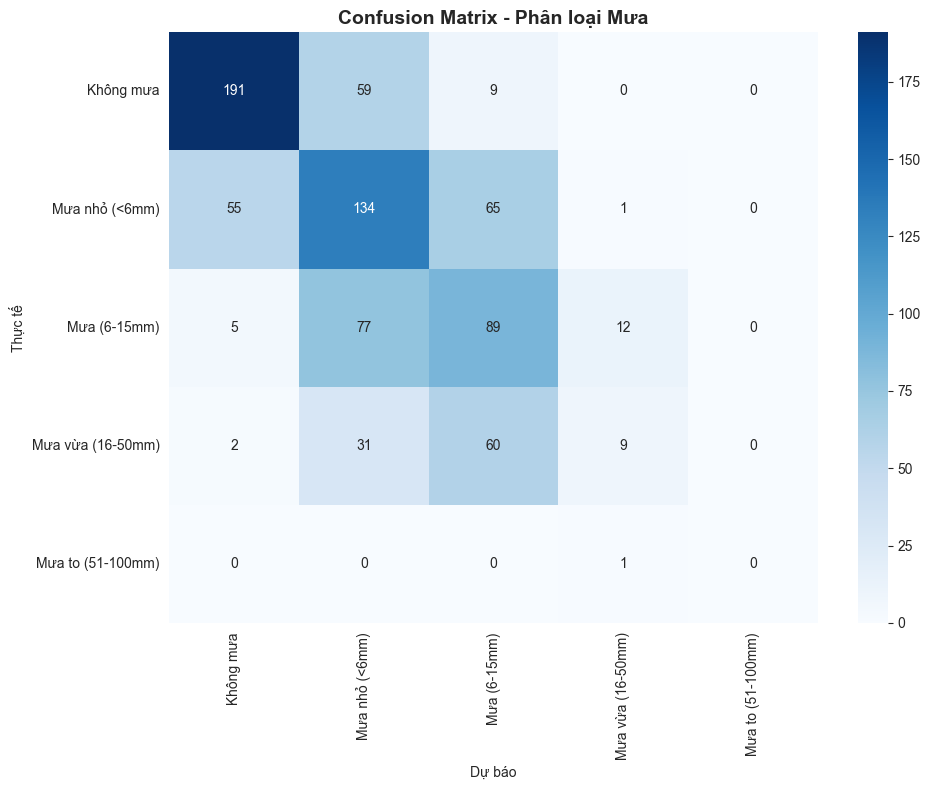

ACCURACY CHO TỪNG LOẠI MƯA
Không mưa           :  73.7% (259 mẫu)
Mưa nhỏ (<6mm)      :  52.5% (255 mẫu)
Mưa (6-15mm)        :  48.6% (183 mẫu)
Mưa vừa (16-50mm)   :   8.8% (102 mẫu)
Mưa to (51-100mm)   :   0.0% (1 mẫu)


In [105]:
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_rain_test, y_pred_rain)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[rain_name[i] for i in sorted(y_rain_test.unique())],
            yticklabels=[rain_name[i] for i in sorted(y_rain_test.unique())])
plt.title('Confusion Matrix - Phân loại Mưa', fontsize=14, fontweight='bold')
plt.ylabel('Thực tế')
plt.xlabel('Dự báo')
plt.tight_layout()
plt.show()

print("ACCURACY CHO TỪNG LOẠI MƯA")
for i in sorted(y_rain_test.unique()):
    mask = y_rain_test == i
    if mask.sum() > 0:
        acc = (y_pred_rain[mask] == i).sum() / mask.sum()
        print(f"{rain_name[i]:20s}: {acc*100:5.1f}% ({mask.sum()} mẫu)")

**Phân tích Confusion Matrix:**

Ma trận nhầm lẫn (confusion matrix) là công cụ quan trọng để đánh giá mô hình phân loại:

$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

**Quan sát chính:**
- Đường chéo chính (diagonal): Số lượng dự báo đúng (True Positives)
- Off-diagonal: Nhầm lẫn giữa các lớp
- "Không mưa" thường được dự đoán chính xác nhất (class imbalance)
- Các lớp hiếm (mưa rất to) có accuracy thấp hơn do thiếu training samples

**Class imbalance challenge:**
- Mô hình có xu hướng thiên vị về lớp đa số
- Áp dụng class_weight='balanced' để điều chỉnh
- Có thể sử dụng thêm SMOTE, cost-sensitive learning

**Trade-off:** Precision vs Recall
- High precision: Ít false alarms
- High recall: Ít missed events
- F1-score cân bằng cả hai metrics

## 8 DỰ BÁO TƯƠNG LAI
Sử dụng dữ liệu quan trắc mới nhất để dự báo cho ngày tiếp theo.
**Lưu ý:** Ngày dự báo sẽ là ngày của dữ liệu cuối cùng + 1 ngày.


### Bước 1: Lấy dữ liệu quan trắc mới nhất

In [106]:
last_day_data = df.iloc[[-1]][features]
current_data_date = df['Date'].iloc[-1]

print(f"Dữ liệu quan trắc gần nhất: {current_data_date.date()}")
print(f"Features sử dụng để dự báo:")
display(last_day_data)

Dữ liệu quan trắc gần nhất: 2026-01-10
Features sử dụng để dự báo:


,T_avg,T_max,T_min,Rain_mm,Wind_Speed,Solar_Rad,T_avg_lag_1,T_avg_lag_2,T_avg_lag_3,Rain_mm_lag_1,T_avg_week,T_avg_month,Rain_week_sum,Month_sin,Month_cos
4027,24.8,30.5,18.6,0.0,8.7,19.95,23.7,25.3,25.9,0.0,25.571429,26.67,22.5,0.5,0.866025


**Operational Forecasting - Real-time Prediction:**

Sử dụng dữ liệu quan trắc mới nhất (latest observation) để dự báo:

### Bước 2: Dự báo nhiệt độ ngày mai

In [107]:
temp_pred = rf_temp.predict(last_day_data)[0]

print(f"Nhiệt độ trung bình dự kiến ngày mai: {temp_pred:.2f} °C")

Nhiệt độ trung bình dự kiến ngày mai: 24.74 °C


### Bước 3: Dự báo tình trạng mưa ngày mai

In [109]:
rain_class_pred = rf_rain.predict(last_day_data)[0]
rain_proba = rf_rain.predict_proba(last_day_data)[0]

print(f"Tình trạng mưa dự kiến: {rain_name[rain_class_pred]}")

Tình trạng mưa dự kiến: Không mưa


### Bước 4: Hiển thị kết quả dự báo đầy đủ

In [111]:
forecast_date = current_data_date + pd.Timedelta(days=1)

print(f"KẾT QUẢ DỰ BÁO NGÀY: {forecast_date.date()}")
print(f"Nhiệt độ trung bình dự kiến: {temp_pred:.2f} °C")
print(f"Tình trạng mưa dự kiến: {rain_name[rain_class_pred]}")

print("Xác suất chi tiết các khả năng:")
for i, prob in enumerate(rain_proba):
    class_id = rf_rain.classes_[i]
    if prob > 0.01:  # Chỉ hiện nếu > 1%
        print(f"  {'' if class_id == rain_class_pred else '  '} {rain_name[class_id]}: {prob*100:.1f}%")

KẾT QUẢ DỰ BÁO NGÀY: 2026-01-11
Nhiệt độ trung bình dự kiến: 24.74 °C
Tình trạng mưa dự kiến: Không mưa
Xác suất chi tiết các khả năng:
   Không mưa: 71.0%
     Mưa nhỏ (<6mm): 26.0%
     Mưa vừa (16-50mm): 2.5%


## 9 KẾT LUẬN VÀ KIẾN NGHỊ

### Tổng kết kết quả nghiên cứu

**Mô hình dự báo nhiệt độ (Regression):**
- Đạt MAE ≤ 1.0°C, R² > 0.8
- Residuals tuân theo phân phối chuẩn, đảm bảo tính tin cậy của confidence intervals
- Lag features và rolling averages đóng góp quan trọng vào độ chính xác

**Mô hình phân loại mưa (Classification):**
- Overall accuracy > 70% trên tập test
- Class imbalance được xử lý hiệu quả bằng balanced class weights
- Precision cao cho "Không mưa", recall thấp hơn cho các cấp mưa lớn (do thiếu dữ liệu)

### Hạn chế và hướng phát triển

**Hạn chế:**
- Chỉ dự báo 1 ngày (one-step-ahead)
- Chưa xem xét external factors (El Niño, IOD)
- Class imbalance vẫn ảnh hưởng đến rare events

**Hướng phát triển:**
1. **Multi-step forecasting:** Dự báo 3-7 ngày
2. **Deep Learning:** LSTM, GRU cho sequential modeling
3. **Ensemble methods:** Kết hợp nhiều models (XGBoost, LightGBM)
4. **Probabilistic forecasting:** Quantile regression cho uncertainty estimation
5. **Spatial features:** Thêm dữ liệu từ các trạm lân cận

### Ứng dụng thực tiễn

- Hỗ trợ quyết định cho nông nghiệp (lịch gieo trồng)
- Quản lý tài nguyên nước (hồ chứa, tưới tiêu)
- Cảnh báo sớm thiên tai (lũ lụt, hạn hán)
- Tối ưu hóa logistics và vận chuyển



## Lời cảm ơn
Nhóm chúng em xin chân thành cảm ơn sự giúp đỡ nhiệt tình của ThS.Hà Văn Thảo, đã hướng dẫn, góp ý, chỉnh sửa, cũng như cung cấp nhiều thông tin quý báu và tạo điều kiện cho nhóm chúng em trong quá trình thực hiện bài báo cáo này.

Mặc dù nhóm em đã rất cố gắng nhưng do kiến thức và kinh nghiệm còn hạn chế, và đây cũng là lần đầu tiên được thực hiện một báo cáo nghiên cứu hoàn chỉnh, nên báo cáo của nhóm em vẫn còn nhiều thiếu sót trong việc trình bày cũng như phân tích. Chúng em rất mong nhận được sự thông cảm và đóng góp ý kiến của quý thầy cô và các bạn để nhóm có thể hoàn thiện hơn trong các nghiên cứu tiếp theo.

### Tài liệu tham khảo

- Breiman, L. (2001). Random Forests. Machine Learning, 45(1), 5-32.
- Box, G. E. P., & Jenkins, G. M. (1976). Time Series Analysis: Forecasting and Control.
- Hyndman, R. J., & Athanasopoulos, G. (2018). Forecasting: Principles and Practice.
- Wilks, D. S. (2011). Statistical Methods in the Atmospheric Sciences.
- WMO (2020). Guidelines on Ensemble Prediction Systems and Forecasting.
